try to give different features different importance

problems to solve:
- implement attention and self attention
- combined with MDN/ or without MDN, only MLP combined with attention!
- fix the input features dimension?
- some feature may contain NaN, assign it a value but fix the attention under a threshold
- [maxout](https://github.com/Duncanswilson/maxout-pytorch/blob/master/maxout_pytorch.ipynb)
- [ptrnetwork](https://github.com/uhauha2929/examples/blob/master/PtrNet.ipynb)

In [3]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
import h5py
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [4]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

## self attention

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        # (B, L, H) -> (B , L, 1)
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
        # (B, L, H) * (B, L, 1) -> (B, H)
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        return outputs, weights

class AttnClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.attention = SelfAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def set_embedding(self, vectors):
        self.embedding.weight.data.copy_(vectors)

    def forward(self, inputs, lengths):
        batch_size = inputs.size(1)
        # (L, B)
        embedded = self.embedding(inputs)
        # (L, B, E)
        packed_emb = nn.utils.rnn.pack_padded_sequence(embedded, lengths)
        out, hidden = self.lstm(packed_emb)
        out = nn.utils.rnn.pad_packed_sequence(out)[0]
        out = out[:, :, :self.hidden_dim] + out[:, :, self.hidden_dim:]
        # (L, B, H)
        embedding, attn_weights = self.attention(out.transpose(0, 1))
        # (B, HOP, H)
        outputs = self.fc(embedding.view(batch_size, -1))
        # (B, 1)
        return outputs, attn_weights

In [7]:
from torchtext import data
from torchtext import datasets
from torchtext.vocab import GloVe
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
from tqdm import tqdm

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
embedding_dim = 200
hidden_dim = 200
epochs = 5

In [10]:
# define Field
TEXT = data.Field(lower=True, include_lengths=True)
LABEL = data.Field(sequential=False)
# make splits for data
train, test = datasets.IMDB.splits(TEXT, LABEL)
# build the vocabulary
TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=embedding_dim))
LABEL.build_vocab(train)

train_iter, test_iter = data.BucketIterator.splits(
        (train, test), sort_key=lambda x:len(x.text),
        sort_within_batch=True, 
        batch_size=batch_size, device=device,
        repeat=False)

downloading aclImdb_v1.tar.gz


.vector_cache/glove.6B.zip: 862MB [04:22, 3.28MB/s]                               
100%|██████████| 400000/400000 [00:22<00:00, 17552.61it/s]


In [11]:
def train(train_iter, model, optimizer, criterion):
    model.train()
    epoch_loss = 0
    bar = tqdm(total=len(train_iter))
    b_ix = 1
    for batch in train_iter:
        (x, x_l), y = batch.text, batch.label - 1
        optimizer.zero_grad()
        outputs, _ = model(x, x_l)
        loss = criterion(outputs.view(-1), y.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if b_ix % 10 == 0:
            bar.update(10)
            bar.set_description('current loss:{:.4f}'.format(epoch_loss / b_ix))
        b_ix += 1
    bar.update((b_ix - 1) % 10)
    bar.close()
    return epoch_loss / len(train_iter)

In [12]:
model = AttnClassifier(len(TEXT.vocab), embedding_dim, hidden_dim).to(device)
model.set_embedding(TEXT.vocab.vectors)
# optim
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)
# train model 
for epoch in range(epochs):
    train(train_iter, model, optimizer, criterion)

current loss:0.0004: 100%|██████████| 391/391 [00:21<00:00, 18.48it/s]


In [13]:
def binary_accuracy(preds, y):
    # round predictions to the closest integer
    rounded_preds = torch.round(F.sigmoid(preds))
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

def accuracy(model, test_iter):
    model.eval()
    total_acc = 0
    for batch in test_iter:
        (x, x_l), y = batch.text, batch.label - 1
        outputs,_ = model(x, x_l)
        total_acc += binary_accuracy(outputs.view(-1), y.float()).item()
    return total_acc / len(test_iter)

In [14]:
print(accuracy(model, test_iter))

0.867814897728698


In [15]:
def highlight(word, attn):
    html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}">{}</span>'.format(html_color, word)

def mk_html(seq, attns):
    html = ""
    for ix, attn in zip(seq, attns):
        html += ' ' + highlight(
            TEXT.vocab.itos[ix],
            attn
        )
    return html + "<br><br>\n"

In [16]:
from IPython.display import HTML, display
with torch.no_grad():
    for batch in test_iter:
        x, x_l = batch.text
        y = batch.label - 1
        outputs, attn_weights = model(x, x_l)
        for i in range(batch_size):
            if torch.round(F.sigmoid(outputs[i])) != y[i].float():
                text = mk_html(x.t()[i].cpu().numpy(), attn_weights[i].cpu().numpy())
                display(HTML(text))
        break

## Ptr network

In [17]:
%pylab inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from torch import FloatTensor
from torch.autograd import Variable
from torch.nn import Linear, Module

from attention import attend


seed = sum(map(ord, 'les bons mots'))
np.random.seed(seed)
torch.manual_seed(seed)


def Volatile(x):
    return Variable(x, volatile=True)

Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'attention'

In [ ]:
class Data(object):
    dim = 10
    min_position, max_position = 3, 7
    q_min = np.random.normal(0, 1, dim).astype(np.float32)
    q_max = np.random.normal(0, 1, dim).astype(np.float32)
    query = np.row_stack([q_min, q_max])

    @staticmethod
    def create_minibatches(n, m, min_length, max_length):
        assert 0 < min_length <= max_length

        minibatches = []
        for i in range(n):
            lengths = np.random.randint(min_length, max_length + 1, m)
            context = np.zeros((m, lengths.max(), Data.dim), dtype=np.float32)
            target = np.zeros((m, 2, Data.dim))
            target_indices = []

            for j, length in enumerate(lengths):
                c = np.random.normal(0, 1, (length, Data.dim))
                k_min = np.argmin(c[:,Data.min_position])
                k_max = np.argmax(c[:,Data.max_position])
                target_min = c[k_min]
                target_max = c[k_max]
                context[j,:length] = c
                target[j,0] = target_min
                target[j,1] = target_max
                target_indices.append((k_min, k_max))

            query = FloatTensor(np.tile(Data.query, (m, 1, 1)))
            context = FloatTensor(context)
            target = FloatTensor(target)
            minibatches.append((query, context, target, lengths, target_indices))
        return minibatches

In [ ]:
class PointerNet(Module):
    def __init__(self, n_hidden):
        super(PointerNet, self).__init__()
        self.n_hidden = n_hidden
        self.f = Linear(Data.dim, n_hidden)
        self.g = Linear(Data.dim, n_hidden)

    def forward(self, q, x, lengths=None, **kwargs):
        batch_size_q, n_queries, dim_q = q.size()
        batch_size_x, n_inputs, dim_x = x.size()
        assert batch_size_q == batch_size_x
        assert dim_q == dim_x
        batch_size = batch_size_q
        dim = dim_q

        q_flat = q.view(batch_size*n_queries, dim)
        u_flat = self.f(q_flat)
        u = u_flat.view(batch_size, n_queries, self.n_hidden)

        x_flat = x.view(batch_size*n_inputs, dim)
        v_flat = self.g(x_flat)
        v = v_flat.view(batch_size, n_inputs, self.n_hidden)

        return attend(u, v, value=x, context_sizes=lengths, **kwargs)

In [ ]:
batch_size = 8

n_train = 200
min_length_train, max_length_train = 5, 14
train_batches = Data.create_minibatches(n_train, batch_size, min_length_train, max_length_train)

n_valid = 100
min_length_valid, max_length_valid = 15, 24
valid_batches = Data.create_minibatches(n_valid, batch_size, min_length_valid, max_length_valid)

In [ ]:
net = PointerNet(7)
opt = torch.optim.RMSprop(net.parameters(), lr=0.001)
mse = torch.nn.MSELoss()

In [ ]:
epoch = 0
max_epochs = 10
while epoch < max_epochs:
    sum_loss = 0
    for query, context, target, lengths, target_indices in train_batches:
        net.zero_grad()
        output = net(Variable(query), Variable(context), lengths=lengths)
        loss = mse(output, Variable(target))
        loss.backward()
        opt.step()
        sum_loss += loss.data[0]
    epoch += 1
    print('[{:2d}] {:5.3f}'.format(epoch, sum_loss / n_train))

In [ ]:
sum_loss = 0
sum_error_min = 0
sum_error_max = 0
for query, context, target, lengths, target_indices in valid_batches:
    weight, output = net(Volatile(query), Volatile(context), lengths=lengths, return_weight=True)

    loss = mse(output, Volatile(target))
    sum_loss += loss.data[0]

    weight = weight.data.numpy()
    for i, (i_min_true, i_max_true) in enumerate(target_indices):
        w_min, w_max = weight[i]
        i_min_pred = w_min.argmax()
        i_max_pred = w_max.argmax()
        sum_error_min += int(i_min_true != i_min_pred)
        sum_error_max += int(i_max_true != i_max_pred)

print('valid loss: {:5.3f}'.format(sum_loss / n_valid))
print('valid error min: {:5.3f}'.format(sum_error_min / (n_valid * batch_size)))
print('valid error max: {:5.3f}'.format(sum_error_max / (n_valid * batch_size)))

In [ ]:
query, context, target, lengths, target_indices = valid_batches[0]
weight, output = net(Volatile(query), Volatile(context), lengths=lengths, return_weight=True)
context = context.numpy()
weight = weight.data.numpy()

colors = sns.color_palette('husl', 3)
fig, axs = plt.subplots(batch_size, 2, figsize=(10, 10), sharex=True, sharey=True)
axs_min, axs_max = axs[:,0], axs[:,1]

for i, (i_min, i_max) in enumerate(target_indices):
    length = lengths[i]
    w_min, w_max = weight[i]
    c_min = [context[i,j,Data.min_position] for j in range(length)]
    c_max = [context[i,j,Data.max_position] for j in range(length)]

    axs_min[i].axvline(i_min, zorder=1, color=colors[2], label='min value')
    axs_min[i].bar(np.arange(length) - 0.4, c_min, zorder=2, color=colors[1], lw=0, label='values')
    axs_min[i].plot(np.arange(length), w_min[:length], zorder=3, color=colors[0], label='attention')

    axs_max[i].axvline(i_max, zorder=1, color=colors[2], label='max value')
    axs_max[i].bar(np.arange(length) - 0.4, c_max, zorder=2, color=colors[1], lw=0, label='values')
    axs_max[i].plot(np.arange(length), w_max[:length], zorder=3, color=colors[0], label='attention')

axs_min[0].set_title('Minimum')
axs_max[0].set_title('Maximum')
axs_max[0].legend(loc='best')    
axs_min[0].legend(loc='best')
axs_max[0].legend(loc='best')
axs_min[-1].set_xlabel('position')
axs_max[-1].set_xlabel('position')
plt.tight_layout()

## MLP with attention
use the idea from MOTIF problem

In [22]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers.merge import Multiply
from keras.models import Model
from keras.layers.merge import Concatenate, Add
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D, AveragePooling1D
from keras.layers.convolutional import UpSampling1D, UpSampling2D
from keras.regularizers import l2, l1, l1_l2
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.recurrent import LSTM
from keras import backend as K
import tensorflow as tf

def set_keras_num_threads(n_threads):
    from keras import backend as K
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.intra_op_parallelism_threads = n_threads
    config.inter_op_parallelism_threads = n_threads
    K.set_session(tf.Session(config=config))
    
set_keras_num_threads(2)

import h5py

(0, 1)

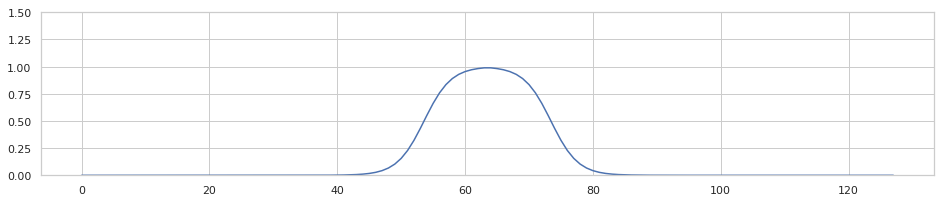

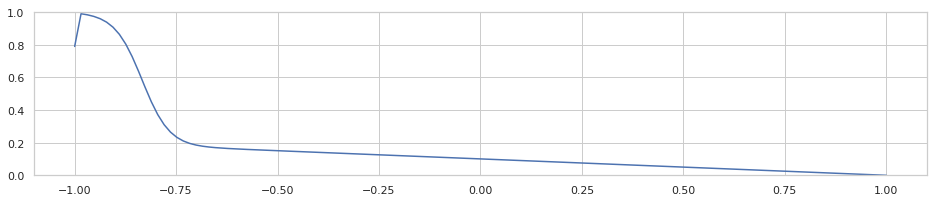

In [23]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def soft_window_numpy(x, w=1, c=0, t=10.0):
    y_curve = np.where(x <= c,
                       sigmoid(t*(x - (c - 0.5*w))),
                       sigmoid(t*(-x + (c + 0.5*w))))
    return y_curve

def soft_window2(x, w=0.5, c=0, k=0.25, t=10.0):
    y_curve = np.where(x <= c,
                       sigmoid(t*(x - (c - 0.5*w))),
                       sigmoid(t*(-x + (c + 0.5*w))))
    y_linear = np.where(x <= c, x + 1 - c, -x + 1 + c)
    y_linear = np.where(x <= c, (x + 1)/(c + 1), (x - 1)/(c - 1))
    return 0.8*y_curve + 0.2*y_linear

x = np.linspace(-1, 1, 128, dtype=np.float32)
window = soft_window_numpy(x, c=64/64 - 1, w=20*2/128, t=30.0)
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(np.arange(128), window)
ax.set_ylim(0, 1.5)

x = np.linspace(-1, 1, 128, dtype=np.float32)
window2 = soft_window2(x, c=-0.99, w=20*2/128, k=0.1, t=30.0)
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(x, window2)
ax.set_ylim(0, 1)

In [26]:
def conv_network(input_layer):
    output = Conv1D(64, 8, padding='valid', kernel_regularizer=l2(0.0005))(input_layer)
    output = Activation('relu')(output)
    output = MaxPooling1D(2)(output)
    output = Conv1D(64, 4, padding='valid', kernel_regularizer=l2(0.0005))(output)
    output = Activation('relu')(output)
    output = MaxPooling1D(2)(output)
    output = Flatten()(output)
    #output = Dense(64, kernel_regularizer=l2(0.0001))(output)
    return output

def soft_window(x, c, w, t):
    c = K.reshape(c, (-1, 1))
    w = K.reshape(w, (-1, 1))
    return K.switch(x <= c, 
                    K.sigmoid(t*(x - (c - 0.5*w))),
                    K.sigmoid(t*(-x + (c + 0.5*w))))
    
def direct_cnn(window_size=128, n_channels=4):
    input_layer = Input(shape=(window_size, n_channels))
    output = conv_network(input_layer)
    output = Dense(1)(output)
    output = Activation('sigmoid')(output)
    model = Model(inputs=[input_layer], outputs=[output])
    return model
    
def attention_cnn(window_size=128, n_channels=4, t=15.0):
    def attention_function(params):
        x = np.linspace(-1, 1, window_size).astype(np.float32).reshape((1, window_size))
        c = K.reshape(params, (-1, 1))
        c = K.tanh(c)
        #c = K.reshape(params[:, 0], (-1, 1))
        #w = K.reshape(params[:, 1], (-1, 1))
        #w = K.exp(w)
        w = 20*2.0/window_size
        k = 0.001
        y_linear = [(x + 1)/(c + 1), (x - 1)/(c - 1)]
        y_linear = [(x + 1 - c), (-x + 1 + c)]
        y_curve  =  [K.sigmoid(t*(x - (c - 0.5*w))), K.sigmoid(t*(-x + (c + 0.5*w)))]
        y = K.switch(x <= c, 
                     (1 - k)*y_curve[0] + k*y_linear[0],
                     (1 - k)*y_curve[1] + k*y_linear[1])
        y = K.expand_dims(y, axis=-1)
        return y
    
    input_layer = Input(shape=(window_size, n_channels))
    conv_attention = conv_network(input_layer)
    attention_params = Dense(64, name='attention_dense1', activation='relu')(conv_attention)
    attention_params = Dense(64, name='attention_dense2', activation='relu')(attention_params)
    attention_params = Dense(1, name='attention_params')(attention_params)
    attention = Lambda(attention_function, name='attention')(attention_params)
    weighted_input = Multiply(name='multiply_attention')([input_layer, attention])
    conv_predict = conv_network(weighted_input)
    output = Dense(1, kernel_regularizer=l2(0.0005))(conv_predict)
    output = Activation('sigmoid')(output)
    
    model = Model(inputs=[input_layer], outputs=[output])
    return model, attention_params, attention

def stochastic_attention_cnn(window_size=128, n_channels=4, t=10.0, 
                             n_sampler=10, sampler_stddev=1.0):
    def attention_function(params):
        x = np.linspace(-1, 1, window_size).astype(np.float32).reshape((1, window_size))
        c = K.reshape(params, (-1, 1))
        c = K.tanh(c)
        #c = K.reshape(params[:, 0], (-1, 1))
        #w = K.reshape(params[:, 1], (-1, 1))
        #w = K.exp(w)
        w = 20*2.0/window_size
        y_curve  =  [K.sigmoid(t*(x - (c - 0.5*w))), K.sigmoid(t*(-x + (c + 0.5*w)))]
        y = K.switch(x <= c, y_curve[0], y_curve[1])
        y = K.expand_dims(y, axis=-1)
        return y

    def attention_sampler(attention_params):
        n_samples = K.shape(attention_params)[0]
        noise = K.random_normal((n_samples, n_sampler, 1), stddev=sampler_stddev*50/window_size)
        attention_params = K.expand_dims(attention_params, axis=1)
        attention_params = attention_params + noise
        attention_params = K.reshape(attention_params, (-1, 1))
        
        c = attention_params
        x = np.linspace(-1, 1, window_size).astype(np.float32).reshape((1, window_size))
        c = K.tanh(c)
        w = 20*2.0/window_size
        y_curve  =  [K.sigmoid(t*(x - (c - 0.5*w))), K.sigmoid(t*(-x + (c + 0.5*w)))]
        y = K.switch(x <= c, y_curve[0], y_curve[1])
        y = K.expand_dims(y, axis=-1)
        return y
        
        
    input_layer = Input(shape=(window_size, n_channels))
    conv_attention = conv_network(input_layer)
    attention_params = Dense(64, name='attention_dense1', activation='relu')(conv_attention)
    attention_params = Dense(64, name='attention_dense2', activation='relu')(attention_params)
    attention_params = Dense(1, name='attention_params')(attention_params)
    
    attention = Lambda(lambda x: attention_sampler(x), name='attention_sampler')(attention_params)
    repeated_input = Lambda(lambda x: K.repeat_elements(x, n_sampler, axis=0),
                            name='repeated_input')(input_layer)
    weighted_input = Multiply(name='multiply_attention')([repeated_input, attention])
    conv_predict = conv_network(weighted_input)
    output = Dense(1, kernel_regularizer=l2(0.0005), name='output_dense')(conv_predict)
    output = Activation('sigmoid', name='output_sigmoid')(output)
    output = Lambda(lambda x: K.mean(K.reshape(x, (-1, n_sampler, 1)), axis=1), name='output_mean')(output)
    
    model = Model(inputs=[input_layer], outputs=[output])
    return model, attention_params, attention
    
#model, attention_params, attention = attention_cnn()


In [27]:
attention_model, attention_params, attention = stochastic_attention_cnn()
attention_model.summary()
attention_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 4)       0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 121, 64)      2112        input_3[0][0]                    
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 121, 64)      0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 60, 64)       0           activation_8[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

In [28]:
attention_model.fit(X, y, batch_size=50, epochs=30)

NameError: name 'X' is not defined

In [25]:
model = direct_cnn()
model.summary()
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 4)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 121, 64)           2112      
_________________________________________________________________
activation_5 (Activation)    (None, 121, 64)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 60, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 57, 64)            16448     
_________________________________________________________________
activation_6 (Activation)    (None, 57, 64)            0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 28, 64)            0         
__________

In [ ]:
model.fit(X, y, batch_size=25, epochs=30)